<a href="https://colab.research.google.com/github/mahmoudta74/FIDVR/blob/main/FIDVR_Khorasan_Test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.optim as optim

torch.set_printoptions(linewidth=120) #Disply Option for output
torch.set_grad_enabled(True)          # already on by default\


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.8.1+cu101
0.9.1+cu101


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/result_rms1.csv')
data = df.to_numpy()
df

,t,u_asadabad3,phi_asadabad3,u_bardskn3,phi_bardskn3,u_beihagh3,phi_beihagh3,u_birjand3,phi_birjand3,u_bushruye3,phi_bushruye3,u_dargaz3,phi_dargaz3,u_davarzan3,phi_davarzan3,u_dolatabad3,phi_dolatabad3,u_fldkhsn3,phi_fldkhsn3,u_ghaen3,phi_ghaen3,u_gholaman3,phi_gholaman3,u_golbahar3,phi_golbahar3,u_golshahr3,phi_golshahr3,u_gonabad3,phi_gonabad3,u_hajiabad3,phi_hajiabad3,u_istghazd3,phi_istghazd3,u_jlgrkh3,phi_jlgrkh3,u_khaf3,phi_khaf3,u_khajerabi633,phi_khajerabi633,u_kohsangi633,...,index_mchnelec3,index_mehrgan3,index_nehbandan3,index_neishabour3,index_nmyshgh3,index_pardis3,index_rashtkhr3,index_sabzvar3,index_sahel3,index_sahlabad3,index_salehabad3,index_sangan3,index_sangbast3,index_sarakhs3,index_sarayan3,index_sarbishe3,index_sedeh3,index_simnbjn3,index_solat3,index_tabas3,index_tossG6,index_trbtjam3,index_abousaed3,index_ghazi3(1),index_trbathydarieh3,index_kashmar3,index_attar3,index_bjnurd3,index_jajarm3,index_dashtjvn3,index_shirvan3,index_sltnabad3,index_feizabad3,index_ferdos3,index_ghuchan3,index_tous633(2),index_tous633(4),index_fariman3,index_kheirabad3,index_taybad3
0,0.000000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125889,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981056,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830332,0.904259,32.974279,0.957576,34.663830,0.950858,30.573864,0.910036,34.350688,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386361,0.941725,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
1,0.050000,0.937805,35.653386,0.920537,33.261717,0.924198,33.724077,0.944647,35.231376,0.964858,34.125890,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981057,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266389,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350689,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403754,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
2,0.100000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125890,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981057,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350689,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
3,0.150000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125889,0.945451,36.691673,0.915904,33.460124,0.945539,34.114064,0.989192,32.743297,0.972371,33.981056,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350688,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621

No handles with labels found to put in legend.


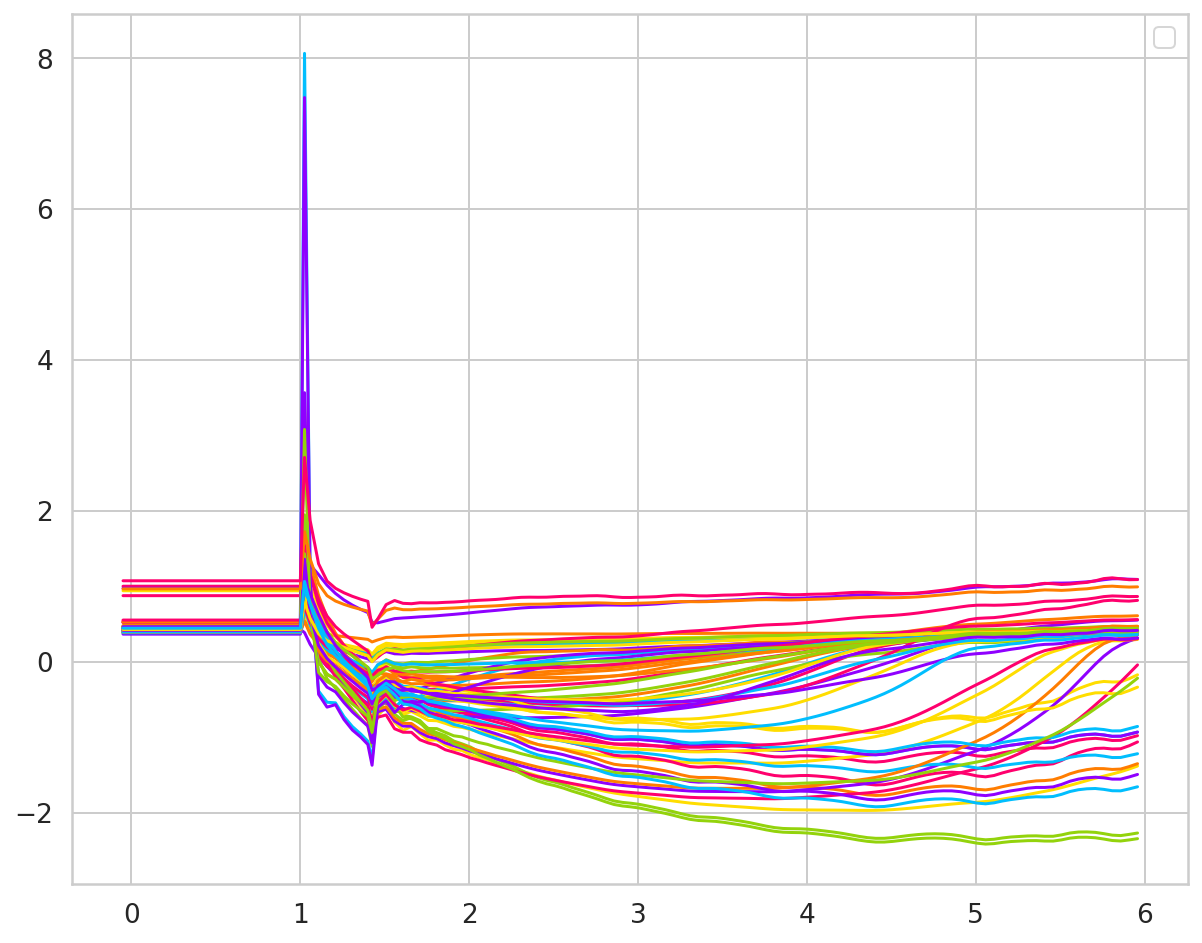

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data[0:120,0], data[0:120,123:184]);
plt.legend()

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(data[0:2000, [1,2,122]])
train_data = scaler.transform(data[0:2000, [1,2,122]])
test_data  = scaler.transform(data[2000:, [1,2,122]])

In [ ]:
test_data.shape

(444, 3)

(2000, 3)

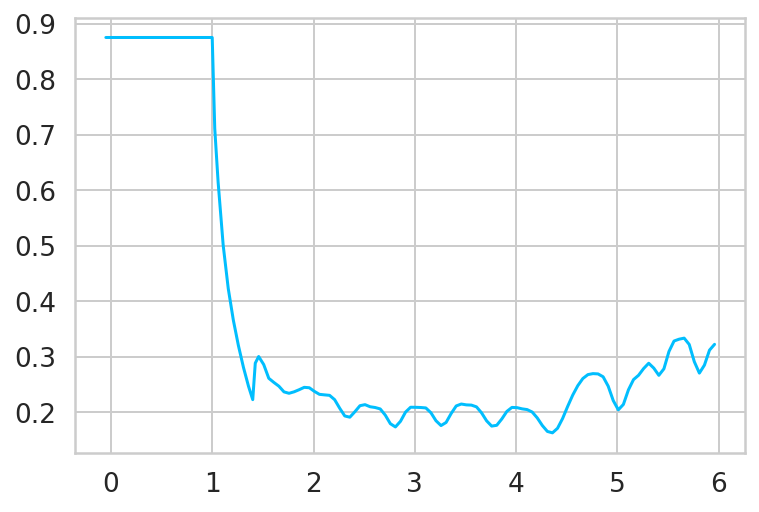

In [ ]:
plt.plot(data[0:120,0], train_data[0:120,0]);
train_data.shape

In [ ]:
def create_sequences(data, seq_lenght):
    xs = []
    ys = []

    for i in range(len(data) - seq_lenght -1):
        x = data[i : (i+seq_length)]
        y = data[(i+ seq_length), 2]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 25
X_train, y_train = create_sequences(train_data, seq_length)
X_test , y_test  = create_sequences(test_data , seq_length)

In [ ]:
print(X_train.shape,'\t', y_train.shape)
print(X_test.shape,'\t', y_test.shape)

(1974, 25, 3) 	 (1974,)
(418, 25, 3) 	 (418,)


In [125]:
# You should build your custom dataset as below.
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, Data, target, Transform= None):
        self.data = Data
        self.label = target
        self.Transform = Transform
        
    def __getitem__(self, index):
        #r = self.data.iloc[index]
        label = torch.tensor(self.label[index], dtype= torch.float32)  
        sample = torch.tensor(self.data[index], dtype= torch.float32)
        if self.Transform:
            sample = self.Transform(sample)
        return (sample, label)

    def __len__(self):
        return self.data.shape[0]


In [ ]:
# You can then use the prebuilt data loader. 
train_set = CustomDataset(X_train, y_train, Transform= None)
train_loader = torch.utils.data.DataLoader(dataset= train_set,
                                           batch_size=64, drop_last=True, 
                                           shuffle=False)

test_set = CustomDataset(X_test, y_test, Transform= None)
test_loader = torch.utils.data.DataLoader(dataset= test_set,
                                           batch_size=64, drop_last=True,
                                           shuffle=False)

In [ ]:
data, label = next(iter(train_loader))
print(data.shape ,'\t', label.shape)

torch.Size([64, 25, 3]) 	 torch.Size([64])


In [ ]:
class My_Net(nn.Module):

    def __init__(self,seq_len, n_features, n_hidden, n_layers):
        super(My_Net, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size= n_features, hidden_size= n_hidden,
                             num_layers = n_layers, batch_first = True,
                             dropout = 0.3
                             )
            

        self.linear = nn.Linear(in_features= n_hidden, out_features= 1)

    def reset_hidden_state(self):
        self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

    def forward(self, x):

        h0 = torch.randn(self.n_layers, 64, self.n_hidden)  # (batch_size= 64 )
        c0 = torch.randn(self.n_layers, 64, self.n_hidden)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.linear(hn)

        return out

In [ ]:
model = My_Net( seq_len=25 ,n_features=3 , n_hidden=128 , n_layers=2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for epoch in range(20):

    total_train_loss = 0
    total_test_loss = 0

    for batch in train_loader: 
        data, label = batch 

        preds = model(data)
        train_loss = loss_fn(preds, label)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step() 
        total_train_loss += train_loss.item() 

    with torch.no_grad():
        for batch in test_loader: 
            data, label = batch 
            preds = model(data) 
            test_loss = loss_fn(preds, label)
            total_test_loss += test_loss.item()
    

    print(
        "epoch", epoch, 
        "total_train_loss", total_train_loss, 
        "total_test_loss:", total_test_loss
    )


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([2, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 total_train_loss 3.1687774534220807 total_test_loss: 0.09124920470640063
epoch 1 total_train_loss 0.14777258540561888 total_test_loss: 0.06757468328578398
epoch 2 total_train_loss 0.10717399106943049 total_test_loss: 0.06032672894070856
epoch 3 total_train_loss 0.09422355622518808 total_test_loss: 0.05438965174835175
epoch 4 total_train_loss 0.08268094799132086 total_test_loss: 0.05286040095961653
epoch 5 total_train_loss 0.07368012702499982 total_test_loss: 0.052024540258571506
epoch 6 total_train_loss 0.0701501084404299 total_test_loss: 0.05169528974511195
epoch 7 total_train_loss 0.06650466325663729 total_test_loss: 0.05043476503487909
epoch 8 total_train_loss 0.06629042337590363 total_test_loss: 0.050816818460589275
epoch 9 total_train_loss 0.06684673228301108 total_test_loss: 0.0509803142194869
epoch 10 total_train_loss 0.06514237516967114 total_test_loss: 0.05052217381307855
epoch 11 total_train_loss 0.06622545346181141 total_test_loss: 0.0504593878868036
epoch 12 total_t

In [ ]:
with torch.no_grad():
    preds = []
    for batch in test_loader:
        data, label = batch 
        preds.append(model(data))

preds[0].shape
 

NameError: ignored

In [ ]:
x = []
for i in range(len(preds)):
    x.append(preds[i][0].squeeze())

In [ ]:
y = torch.cat((x[0], x[1], x[2], x[3], x[4], x[5]), 0)

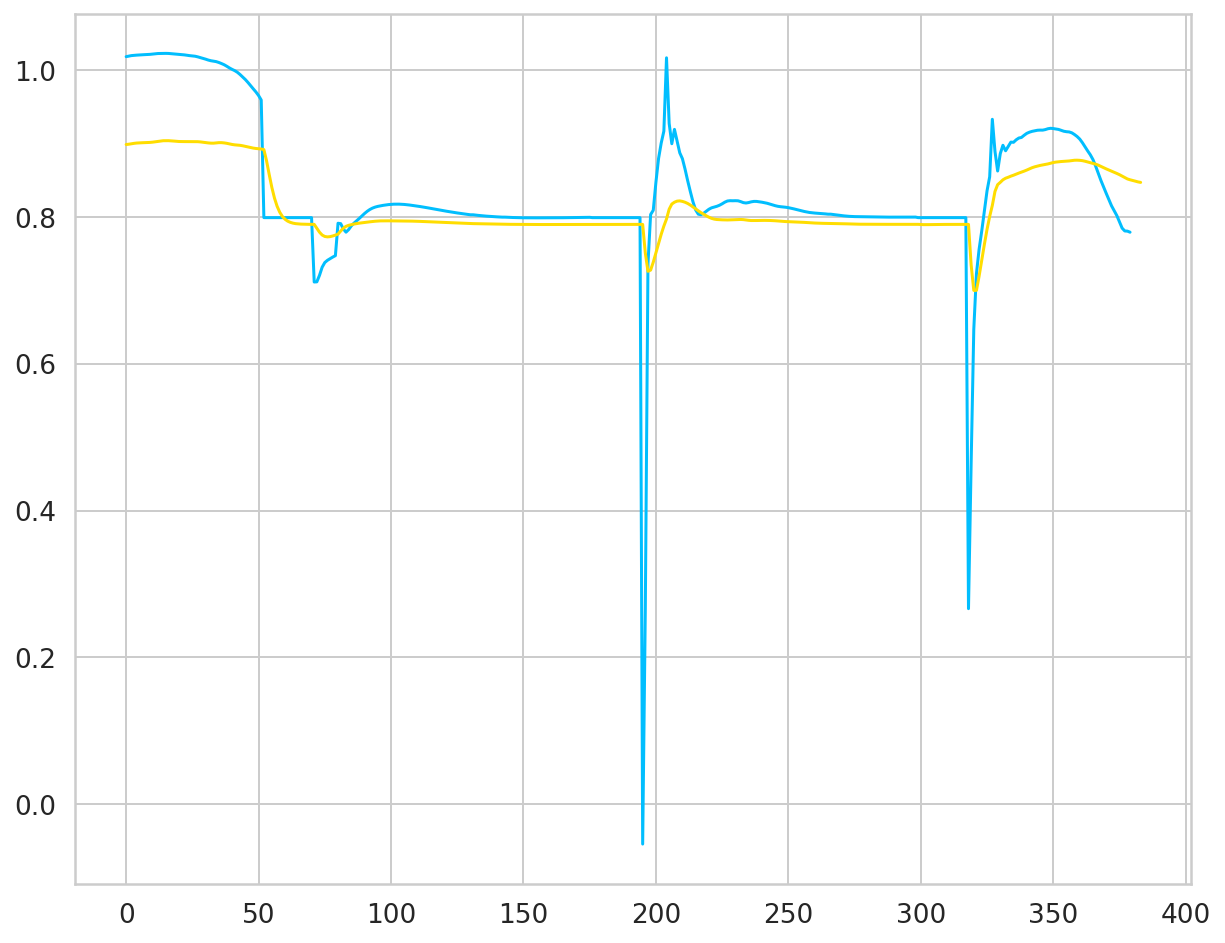

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y_test[0:380])
plt.plot(y)

# predict only index by using index

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/result_rms1.csv')
data = df.to_numpy()
df

,t,u_asadabad3,phi_asadabad3,u_bardskn3,phi_bardskn3,u_beihagh3,phi_beihagh3,u_birjand3,phi_birjand3,u_bushruye3,phi_bushruye3,u_dargaz3,phi_dargaz3,u_davarzan3,phi_davarzan3,u_dolatabad3,phi_dolatabad3,u_fldkhsn3,phi_fldkhsn3,u_ghaen3,phi_ghaen3,u_gholaman3,phi_gholaman3,u_golbahar3,phi_golbahar3,u_golshahr3,phi_golshahr3,u_gonabad3,phi_gonabad3,u_hajiabad3,phi_hajiabad3,u_istghazd3,phi_istghazd3,u_jlgrkh3,phi_jlgrkh3,u_khaf3,phi_khaf3,u_khajerabi633,phi_khajerabi633,u_kohsangi633,...,index_mchnelec3,index_mehrgan3,index_nehbandan3,index_neishabour3,index_nmyshgh3,index_pardis3,index_rashtkhr3,index_sabzvar3,index_sahel3,index_sahlabad3,index_salehabad3,index_sangan3,index_sangbast3,index_sarakhs3,index_sarayan3,index_sarbishe3,index_sedeh3,index_simnbjn3,index_solat3,index_tabas3,index_tossG6,index_trbtjam3,index_abousaed3,index_ghazi3(1),index_trbathydarieh3,index_kashmar3,index_attar3,index_bjnurd3,index_jajarm3,index_dashtjvn3,index_shirvan3,index_sltnabad3,index_feizabad3,index_ferdos3,index_ghuchan3,index_tous633(2),index_tous633(4),index_fariman3,index_kheirabad3,index_taybad3
0,0.000000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125889,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981056,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830332,0.904259,32.974279,0.957576,34.663830,0.950858,30.573864,0.910036,34.350688,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386361,0.941725,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
1,0.050000,0.937805,35.653386,0.920537,33.261717,0.924198,33.724077,0.944647,35.231376,0.964858,34.125890,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981057,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266389,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350689,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403754,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
2,0.100000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125890,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981057,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350689,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
3,0.150000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125889,0.945451,36.691673,0.915904,33.460124,0.945539,34.114064,0.989192,32.743297,0.972371,33.981056,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350688,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621

In [ ]:

train_data = data[0:11000, 124].reshape(-1, 1)
test_data  = data[11000: , 124].reshape(-1, 1)

print(train_data.shape, '\t', test_data.shape)

(11000, 1) 	 (1130, 1)


In [ ]:
def create_sequences(data, seq_lenght):
    xs = []
    ys = []

    for i in range(len(data) - seq_lenght -1):
        x = data[i : (i+seq_length)]
        y = data[(i+ seq_length)]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
seq_length = 25
X_train, y_train = create_sequences(train_data, seq_length)
X_test , y_test  = create_sequences(test_data , seq_length)

print(X_train.shape,'\t', y_train.shape)
print(X_test.shape,'\t', y_test.shape)

(10974, 25, 1) 	 (10974, 1)
(1104, 25, 1) 	 (1104, 1)


In [ ]:
train_set = CustomDataset(X_train, y_train, Transform= None)
train_loader = torch.utils.data.DataLoader(dataset= train_set,
                                           batch_size=64, drop_last=True, 
                                           shuffle=False)

test_set = CustomDataset(X_test, y_test, Transform= None)
test_loader = torch.utils.data.DataLoader(dataset= test_set,
                                           batch_size=1, drop_last=True,
                                           shuffle=False)

In [ ]:
class My_Net(nn.Module):

    def __init__(self,seq_len, n_features, n_hidden, n_layers):
        super(My_Net, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size= n_features, hidden_size= n_hidden,
                             num_layers = n_layers, batch_first = True,
                             dropout = 0.3
                             )
            

        self.linear = nn.Linear(in_features= n_hidden, out_features= 1)

    def reset_hidden_state(self):
        self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

    def forward(self, x):

        h0 = torch.randn(self.n_layers, x.size(0), self.n_hidden)  # (batch_size= x.size(0) )
        c0 = torch.randn(self.n_layers, x.size(0), self.n_hidden)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.linear(hn)

        return out

In [ ]:
def weight_reset(m):
    if isinstance(m, nn.LSTM) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
model = My_Net( seq_len=25 ,n_features=1 , n_hidden=128 , n_layers=2)
model.apply(weight_reset)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = torch.nn.MSELoss()

for epoch in range(40):

    total_train_loss = 0
    total_test_loss = 0


    with torch.no_grad():
        for batch in test_loader: 
            data, label = batch 
            preds = model(data) 
            test_loss = loss_fn(preds, label)
            total_test_loss += test_loss.item()

    for batch in train_loader: 
        data, label = batch 

        preds = model(data)
        train_loss = loss_fn(preds, label)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step() 
        total_train_loss += train_loss.item() 


    

    print(
        "epoch", epoch, 
        "total_train_loss", total_train_loss, 
        "total_test_loss:", total_test_loss
    )


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([2, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([2, 64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 total_train_loss 72.43619707395555 total_test_loss: 803.8539201932435
epoch 1 total_train_loss 39.02172491615056 total_test_loss: 168.8611753914547
epoch 2 total_train_loss 34.260355277423514 total_test_loss: 124.93804544506793
epoch 3 total_train_loss 32.881435312126996 total_test_loss: 107.06465846885658
epoch 4 total_train_loss 33.5295997725043 total_test_loss: 97.11609805827902
epoch 5 total_train_loss 31.977772278769407 total_test_loss: 107.32055268689874
epoch 6 total_train_loss 31.402460906188935 total_test_loss: 86.37509448322271
epoch 7 total_train_loss 31.53806425363291 total_test_loss: 80.68477854397656
epoch 8 total_train_loss 30.611461970227538 total_test_loss: 82.10701159152791
epoch 9 total_train_loss 30.31220001191832 total_test_loss: 73.24258960017869
epoch 10 total_train_loss 30.444759772683028 total_test_loss: 70.74596814682678
epoch 11 total_train_loss 29.933966428157873 total_test_loss: 68.20198964296515
epoch 12 total_train_loss 29.83438081239001 total_tes

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Oneshot_Test.csv')
data = df.to_numpy()
t = data[:, 0]
data = data[:,125]

In [ ]:
tst = torch.tensor(data[0:25], dtype=torch.float32).reshape(1,25,1)

In [ ]:
preds = []
with torch.no_grad():
    
    pred = model(tst)[0]
    preds.append(pred.squeeze().item())
    #print(preds)

    for i in range(75):
        tst = torch.roll(tst, -1, 1)
        tst[0,24,0] = pred.squeeze().item()
        #print(tst)
        pred = model(tst)[0]
        preds.append(pred.squeeze().item())

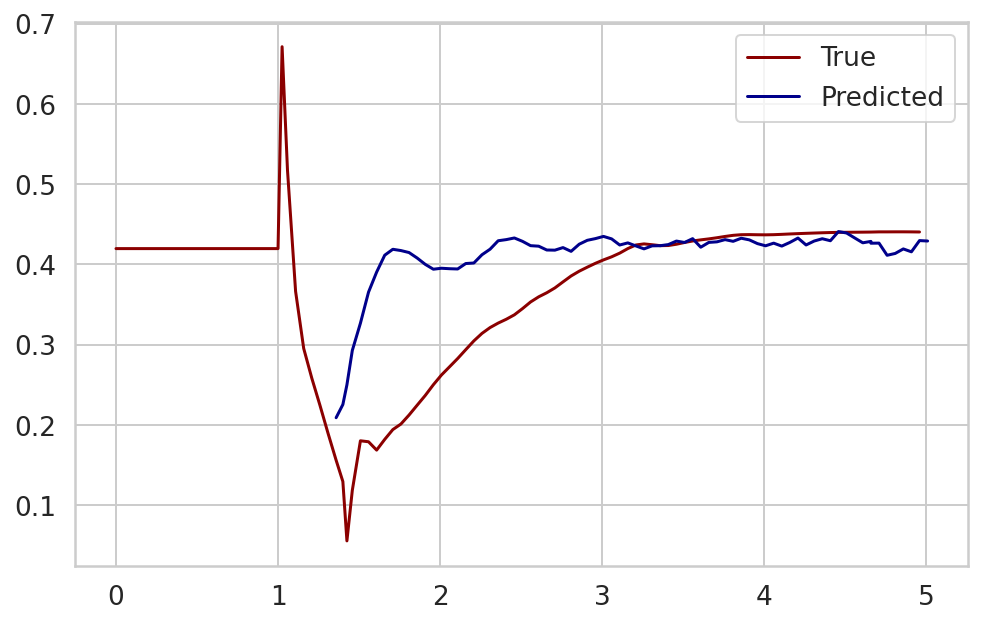

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(t[0:100], data[0:100], label='True', c='darkred')
plt.plot(t[25:101], preds, label='Predicted', c='darkblue')
plt.legend()

# Predict  U&phi  by using  U&phi  (multi-output time series forecasting)

In [159]:
df = pd.read_csv('/content/drive/MyDrive/dataset/result_rms1.csv')
data = df.to_numpy()
df

,t,u_asadabad3,phi_asadabad3,u_bardskn3,phi_bardskn3,u_beihagh3,phi_beihagh3,u_birjand3,phi_birjand3,u_bushruye3,phi_bushruye3,u_dargaz3,phi_dargaz3,u_davarzan3,phi_davarzan3,u_dolatabad3,phi_dolatabad3,u_fldkhsn3,phi_fldkhsn3,u_ghaen3,phi_ghaen3,u_gholaman3,phi_gholaman3,u_golbahar3,phi_golbahar3,u_golshahr3,phi_golshahr3,u_gonabad3,phi_gonabad3,u_hajiabad3,phi_hajiabad3,u_istghazd3,phi_istghazd3,u_jlgrkh3,phi_jlgrkh3,u_khaf3,phi_khaf3,u_khajerabi633,phi_khajerabi633,u_kohsangi633,...,index_mchnelec3,index_mehrgan3,index_nehbandan3,index_neishabour3,index_nmyshgh3,index_pardis3,index_rashtkhr3,index_sabzvar3,index_sahel3,index_sahlabad3,index_salehabad3,index_sangan3,index_sangbast3,index_sarakhs3,index_sarayan3,index_sarbishe3,index_sedeh3,index_simnbjn3,index_solat3,index_tabas3,index_tossG6,index_trbtjam3,index_abousaed3,index_ghazi3(1),index_trbathydarieh3,index_kashmar3,index_attar3,index_bjnurd3,index_jajarm3,index_dashtjvn3,index_shirvan3,index_sltnabad3,index_feizabad3,index_ferdos3,index_ghuchan3,index_tous633(2),index_tous633(4),index_fariman3,index_kheirabad3,index_taybad3
0,0.000000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125889,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981056,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830332,0.904259,32.974279,0.957576,34.663830,0.950858,30.573864,0.910036,34.350688,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386361,0.941725,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
1,0.050000,0.937805,35.653386,0.920537,33.261717,0.924198,33.724077,0.944647,35.231376,0.964858,34.125890,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981057,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266389,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350689,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403754,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
2,0.100000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125890,0.945451,36.691673,0.915904,33.460124,0.945539,34.114065,0.989192,32.743297,0.972371,33.981057,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350689,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621,0.423743,0.417342,0.440600,0.428738,0.966316,1.074059,0.468809,0.465677,0.445535
3,0.150000,0.937805,35.653384,0.920537,33.261717,0.924198,33.724077,0.944647,35.231375,0.964858,34.125889,0.945451,36.691673,0.915904,33.460124,0.945539,34.114064,0.989192,32.743297,0.972371,33.981056,0.930713,34.913893,0.953005,34.571284,0.959597,36.195015,0.956673,35.266388,0.967495,33.830333,0.904259,32.974279,0.957576,34.663830,0.950858,30.573865,0.910036,34.350688,0.943787,...,0.422762,0.434201,0.385141,0.439332,0.398577,0.541487,0.524253,0.420701,0.437877,0.403755,0.452954,0.528158,0.876737,0.463179,0.440658,0.386360,0.941724,0.481437,1.001928,0.457143,0.974858,0.455456,0.436248,0.393320,0.437035,0.433459,0.437841,0.398249,0.417256,0.425785,0.553621

In [160]:
train_data = data[0:11000, [1,2]]
test_data  = data[11000: , [1,2]]

print(train_data.shape, '\t', test_data.shape,'\n')
train_data[0:5]

(11000, 2) 	 (1130, 2) 



array([[ 0.93780474, 35.65338371],
       [ 0.93780473, 35.65338564],
       [ 0.93780472, 35.65338371],
       [ 0.93780471, 35.65338402],
       [ 0.93780471, 35.65338437]])

In [156]:
scaler = MinMaxScaler()
scaler = scaler.fit(test_data)
train_data = scaler.transform(train_data)
test_data  = scaler.transform(test_data)
print(train_data.shape, '\t', test_data.shape, '\n')
train_data[0:5]

(11000, 2) 	 (1130, 2) 



array([[0.88616681, 0.84326106],
       [0.8861668 , 0.84326107],
       [0.88616678, 0.84326106],
       [0.88616678, 0.84326106],
       [0.88616678, 0.84326106]])

In [161]:
def create_sequences(data, seq_lenght):
    xs = []
    ys = []

    for i in range(len(data) - seq_lenght -1):
        x = data[i : (i+seq_length)]
        y1 = data[(i+ seq_length), 0]
        y2 = data[(i+ seq_length), 1]
        xs.append(x)
        ys.append([y1, y2])

    return np.array(xs), np.array(ys)

In [162]:
seq_length = 25
X_train, y_train = create_sequences(train_data, seq_length)
X_test , y_test  = create_sequences(test_data , seq_length)

print(X_train.shape,'\t', y_train.shape)
print(X_test.shape,'\t', y_test.shape)

(10974, 25, 2) 	 (10974, 2)
(1104, 25, 2) 	 (1104, 2)


In [163]:
train_set = CustomDataset(X_train, y_train, Transform= None)
train_loader = torch.utils.data.DataLoader(dataset= train_set,
                                           batch_size=64, drop_last=True, 
                                           shuffle=False)

test_set = CustomDataset(X_test, y_test, Transform= None)
test_loader = torch.utils.data.DataLoader(dataset= test_set,
                                           batch_size=1, drop_last=True,
                                           shuffle=False)

In [164]:
class My_Net(nn.Module):

    def __init__(self,seq_len, n_features, n_hidden, n_layers):
        super(My_Net, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size= n_features, hidden_size= n_hidden,
                             num_layers = n_layers, batch_first = True,
                             dropout = 0.3
                             )
            

        self.linear = nn.Linear(in_features= n_hidden, out_features= 2)

    def reset_hidden_state(self):
        self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

    def forward(self, x):

        h0 = torch.randn(self.n_layers, x.size(0), self.n_hidden)  # (batch_size= x.size(0) )
        c0 = torch.randn(self.n_layers, x.size(0), self.n_hidden)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])

        return out

In [165]:
def weight_reset(m):
    if isinstance(m, nn.LSTM) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [166]:
model1 = My_Net( seq_len=25 ,n_features=2 , n_hidden=128 , n_layers=2)
model.apply(weight_reset)

optimizer = optim.Adam(model1.parameters(), lr=0.0005)
loss_fn = torch.nn.MSELoss()

for epoch in range(50):

    total_train_loss = 0
    total_test_loss = 0


    with torch.no_grad():
        for batch in test_loader: 
            data, label = batch 
            preds = model1(data) 
            test_loss = loss_fn(preds, label)
            total_test_loss += test_loss.item()

    for batch in train_loader: 
        data, label = batch 

        preds = model1(data)
        train_loss = loss_fn(preds, label)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step() 
        total_train_loss += train_loss.item() 


    

    print(
        "epoch", epoch, 
        "total_train_loss", total_train_loss, 
        "total_test_loss:", total_test_loss
    )


epoch 0 total_train_loss 86500.30654907227 total_test_loss: 895142.8248672485
epoch 1 total_train_loss 34237.23709487915 total_test_loss: 362216.54619944096
epoch 2 total_train_loss 17031.39994621277 total_test_loss: 194326.69528739154
epoch 3 total_train_loss 10778.283668398857 total_test_loss: 130917.9168845592
epoch 4 total_train_loss 8572.458379875869 total_test_loss: 109460.06927535567
epoch 5 total_train_loss 7545.885020535439 total_test_loss: 100522.72790020611
epoch 6 total_train_loss 6785.958083199337 total_test_loss: 95252.18486846704
epoch 7 total_train_loss 6148.202612705994 total_test_loss: 90347.97795161378
epoch 8 total_train_loss 5639.245109838899 total_test_loss: 86712.08846277779
epoch 9 total_train_loss 5232.725995334098 total_test_loss: 83289.65885755874
epoch 10 total_train_loss 4899.467820763239 total_test_loss: 80465.14811822411
epoch 11 total_train_loss 4631.5454463581555 total_test_loss: 77843.76953466528
epoch 12 total_train_loss 4419.275174857117 total_test_l

In [178]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Oneshot_Test2.csv')
data = df.to_numpy()
t = data[:, 0]
data = data[:,[1,2]]
data[0:5]

array([[ 0.93780474, 35.65338371],
       [ 0.93780473, 35.65338564],
       [ 0.93780472, 35.65338371],
       [ 0.93780471, 35.65338402],
       [ 0.93780471, 35.65338437]])

In [173]:
data =scaler.transform(data)
data[0:5]

array([[0.88616681, 0.84326106],
       [0.8861668 , 0.84326107],
       [0.88616678, 0.84326106],
       [0.88616678, 0.84326106],
       [0.88616678, 0.84326106]])

In [179]:
tst = torch.tensor(data[0:25], dtype=torch.float32).reshape(1,25,2)

In [180]:
U = []
phi = []
with torch.no_grad():
    
    p = model1(tst)
    U.append(p[0,0].item())
    phi.append(p[0,1].item())
    print(U, phi)

    for i in range(75):
        tst = torch.roll(tst, -1, 1)
        tst[0,24,0] = p[0,0]
        tst[0,24,1] = p[0,1]
        #print(tst)
        p = model1(tst)
        U.append(p[0,0].item())
        phi.append(p[0,1].item())

[0.6233846545219421] [28.733306884765625]


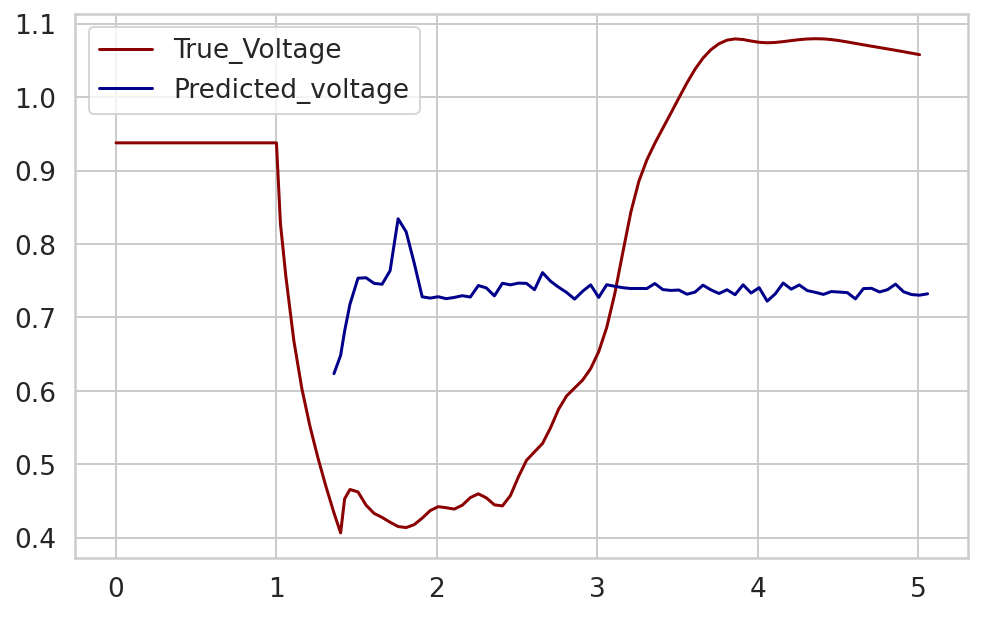

In [181]:
plt.figure(figsize=(8,5))
plt.plot(t[0:100], data[0:100,0], label='True_Voltage', c='darkred')
plt.plot(t[25:101], U, label='Predicted_voltage', c='darkblue')
plt.legend()

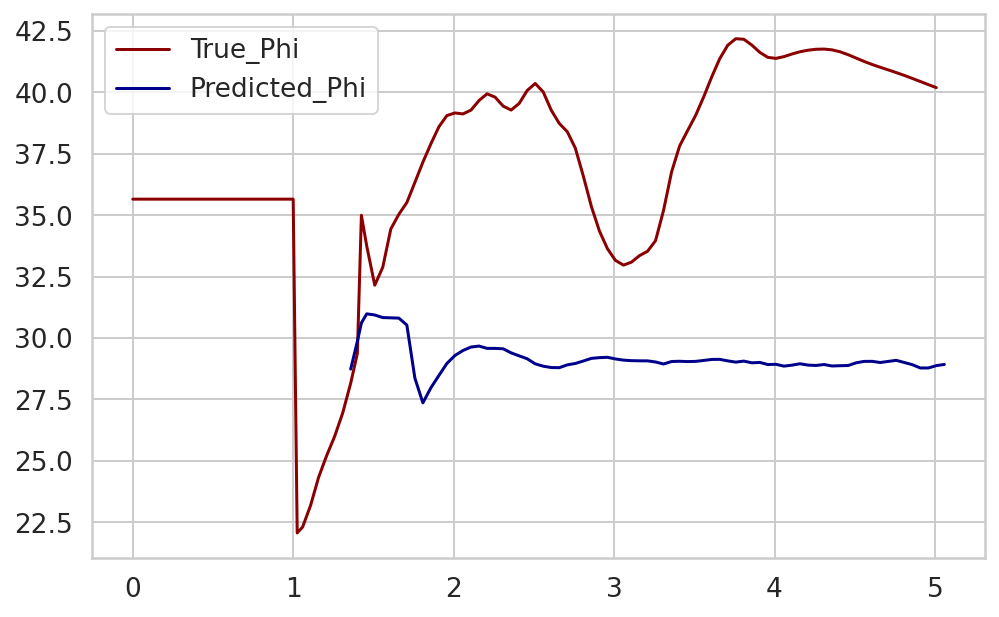

In [182]:
plt.figure(figsize=(8,5))
plt.plot(t[0:100], data[0:100,1], label='True_Phi', c='darkred')
plt.plot(t[25:101], phi, label='Predicted_Phi', c='darkblue')
plt.legend()

# Change data time_step format (index forecasting)

In [209]:
df = pd.read_csv('/content/drive/MyDrive/dataset/result_rms1.csv')
data = df.to_numpy()

In [210]:
train_data = data[0:11000, 123].reshape(-1, 1)
test_data  = data[11000: , 123].reshape(-1, 1)
time = data[:,0]

print(train_data.shape, '\t', test_data.shape,'\n')
train_data[0:5]

(11000, 1) 	 (1130, 1) 



array([[0.38595979],
       [0.38595973],
       [0.38595976],
       [0.38595975],
       [0.38595974]])

In [211]:
def create_sequences(time, data, seq_length, num_run):
    xs = []
    ys = []
    t = time[0]
    j = 0

    for i in range(len(data) - (seq_length*num_run - num_run)):

        if t == 0:
            if j==0:
                x = data[j : (j + seq_length)]
                y = data[(j+ seq_length)]
                xs.append(x)
                ys.append(y)
                j = j+35
                t = time[j]
            else:
                x = data[j+1 : (j+1 + seq_length)]
                y = data[(j+1+ seq_length)]
                xs.append(x)
                ys.append(y)
                j = j+35
                t = time[j]


        else:
            x = data[j+1-seq_length : j+1]
            y = data[j+1]
            xs.append(x)
            ys.append(y)
            j = j+1
            t = time[j+1]

    return np.array(xs), np.array(ys)

In [212]:
seq_length = 35
X_train, y_train = create_sequences(time, train_data, seq_length, num_run=92)
X_test , y_test  = create_sequences(time, test_data , seq_length = seq_length, num_run=11)

print(X_train.shape,'\t', y_train.shape)
print(X_test.shape,'\t', y_test.shape)

(7872, 35, 1) 	 (7872, 1)
(756, 35, 1) 	 (756, 1)


In [213]:
train_set = CustomDataset(X_train, y_train, Transform= None)
train_loader = torch.utils.data.DataLoader(dataset= train_set,
                                           batch_size=64, drop_last=True, 
                                           shuffle=False)

test_set = CustomDataset(X_test, y_test, Transform= None)
test_loader = torch.utils.data.DataLoader(dataset= test_set,
                                           batch_size=1, drop_last=True,
                                           shuffle=False)

In [214]:
class My_Net(nn.Module):

    def __init__(self,seq_len, n_features, n_hidden, n_layers):
        super(My_Net, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_size= n_features, hidden_size= n_hidden,
                             num_layers = n_layers, batch_first = True,
                             dropout = 0.3
                             )
            

        self.linear = nn.Linear(in_features= n_hidden, out_features= 1)

    def reset_hidden_state(self):
        self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

    def forward(self, x):

        h0 = torch.randn(self.n_layers, x.size(0), self.n_hidden)  # (batch_size= x.size(0) )
        c0 = torch.randn(self.n_layers, x.size(0), self.n_hidden)
        output, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])

        return out

In [215]:
model = My_Net( seq_len=35 ,n_features=1 , n_hidden=128 , n_layers=2)
#model.apply(weight_reset)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = torch.nn.MSELoss()

for epoch in range(40):

    total_train_loss = 0
    total_test_loss = 0


    with torch.no_grad():
        for batch in test_loader: 
            data, label = batch 
            preds = model(data) 
            test_loss = loss_fn(preds, label)
            total_test_loss += test_loss.item()

    for batch in train_loader: 
        data, label = batch 

        preds = model(data)
        train_loss = loss_fn(preds, label)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step() 
        total_train_loss += train_loss.item() 


    

    print(
        "epoch", epoch, 
        "total_train_loss", total_train_loss, 
        "total_test_loss:", total_test_loss
    )


epoch 0 total_train_loss 21.615433739734726 total_test_loss: 290.3519177299479
epoch 1 total_train_loss 1.8585933927824954 total_test_loss: 131.56838976717324
epoch 2 total_train_loss 1.3245058207394322 total_test_loss: 103.4703041292944
epoch 3 total_train_loss 0.8296593687382483 total_test_loss: 89.24616098926074
epoch 4 total_train_loss 0.49233175918470806 total_test_loss: 80.4004847936646
epoch 5 total_train_loss 0.31097336673423115 total_test_loss: 76.00753135351897
epoch 6 total_train_loss 0.22452184281701193 total_test_loss: 74.0533389525157
epoch 7 total_train_loss 0.19678814594630012 total_test_loss: 72.24497610791404
epoch 8 total_train_loss 0.1842567670054791 total_test_loss: 69.75179140394465
epoch 9 total_train_loss 0.17319209753691212 total_test_loss: 67.4344750580677
epoch 10 total_train_loss 0.16365175362602713 total_test_loss: 65.45755957705396
epoch 11 total_train_loss 0.15649131467881716 total_test_loss: 63.75227647166756
epoch 12 total_train_loss 0.152136636925718 t

In [225]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Oneshot_Test3.csv')
data = df.to_numpy()
t = data[:, 0]
data = data[:,123]

In [226]:
tst = torch.tensor(data[0:25], dtype=torch.float32).reshape(1,25,1)

In [227]:
preds = []
with torch.no_grad():
    
    pred = model(tst)
    preds.append(pred.squeeze().item())
    #print(preds)

    for i in range(65):
        tst = torch.roll(tst, -1, 1)
        tst[0,24,0] = pred.squeeze().item()
        #print(tst)
        pred = model(tst)[0]
        preds.append(pred.squeeze().item())

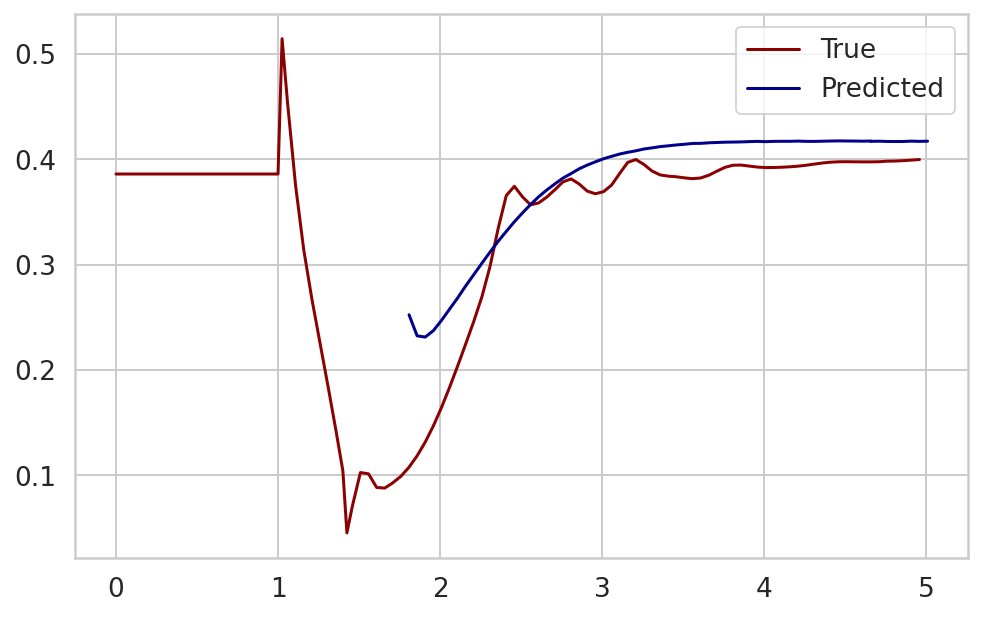

In [228]:
plt.figure(figsize=(8,5))
plt.plot(t[0:100], data[0:100], label='True', c='darkred')
plt.plot(t[35:101], preds, label='Predicted', c='darkblue')
plt.legend()